In [1]:
from functools import partial
import json
import os
import pickle

from datetime import datetime
import ee
import geemap
from multiprocessing.dummy import Pool as ThreadPool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import sys
sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize as sklearn_normalize
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

np.random.seed(1)

In [3]:
DATA_DIR = '../data/training_sites'

with open(os.path.join(DATA_DIR, "tpa_patch_histories_toa.pkl"), 'rb') as file:
    positive_histories = pickle.load(file)
file.close()

with open(os.path.join(DATA_DIR, "negative_patch_histories_toa.pkl"), 'rb') as file:
    negative_histories = pickle.load(file)
file.close()

In [4]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

band_wavelengths = [442, 492, 559, 665, 704, 739, 779, 833, 864, 943, 1610, 2186]

In [5]:
def create_spectrogram_dataset(dataset, dates):
    sites = list(dataset[dates[0]].keys())
    spectrogram_list = []
    for site in sites:
        date_idx_with_data = np.argmax([len(dataset[date][site]['B2']) for date in dates])
        width, height = np.shape(dataset[dates[date_idx_with_data]][site]['B2'])
        for i in range(width):
            for j in range(height):
                spectrogram = []
                for date in dates:
                    if len(dataset[date][site]['B2']) > 0:
                        pixel_vector = []
                        for band in band_descriptions:
                            if dataset[date][site][band][i][j] != -999:
                                pixel_vector.append(dataset[date][site][band][i][j])
                            else:
                                pixel_vector.append(0)
                        spectrogram.append(pixel_vector)
                    else:
                        spectrogram.append([0] * len(band_descriptions))
                spectrogram_list.append(np.transpose(spectrogram))
    
    return np.array(spectrogram_list)

In [6]:
dates = list(negative_histories[0].keys())[:12]
city_spectrograms = create_spectrogram_dataset(negative_histories[0], dates)
bare_earth_spectrograms = create_spectrogram_dataset(negative_histories[1], dates)
adjacent_spectrograms = create_spectrogram_dataset(negative_histories[2], dates)
negative_spectrograms = np.concatenate((city_spectrograms, bare_earth_spectrograms, adjacent_spectrograms))

In [7]:
dates = list(positive_histories.keys())[:12]
positive_spectrograms = create_spectrogram_dataset(positive_histories, dates)

In [8]:
dates = list(positive_histories.keys())[4:16]
positive_spectrograms_2016 = create_spectrogram_dataset(positive_histories, dates)

dates = list(positive_histories.keys())[16:28]
positive_spectrograms_2017 = create_spectrogram_dataset(positive_histories, dates)

dates = list(positive_histories.keys())[28:40]
positive_spectrograms_2018 = create_spectrogram_dataset(positive_histories, dates)

dates = list(positive_histories.keys())[40:52]
positive_spectrograms_2019 = create_spectrogram_dataset(positive_histories, dates)

positive_spectrograms = np.concatenate((positive_spectrograms_2016, 
                                        positive_spectrograms_2017, 
                                        positive_spectrograms_2018, 
                                        positive_spectrograms_2019))

In [9]:
print("Number of Negative Samples:", len(negative_spectrograms))
print("Number of Positive Samples:", len(positive_spectrograms))

Number of Negative Samples: 30730
Number of Positive Samples: 12580


In [10]:
positive_ndvi = []
for sample in positive_spectrograms:
    if sample[7,0] + sample[3,0] > 0:
        ndvi = (sample[7,0] - sample[3,0]) / (sample[7,0] + sample[3,0])
    else:
        ndvi = 0
    positive_ndvi.append(ndvi)
positive_ndvi = np.array(positive_ndvi)

In [11]:
positive_spectrograms = positive_spectrograms[positive_ndvi < 0.5]
print("Number of Positive Samples after NDVI Thresholding:", len(positive_spectrograms))

Number of Positive Samples after NDVI Thresholding: 11438


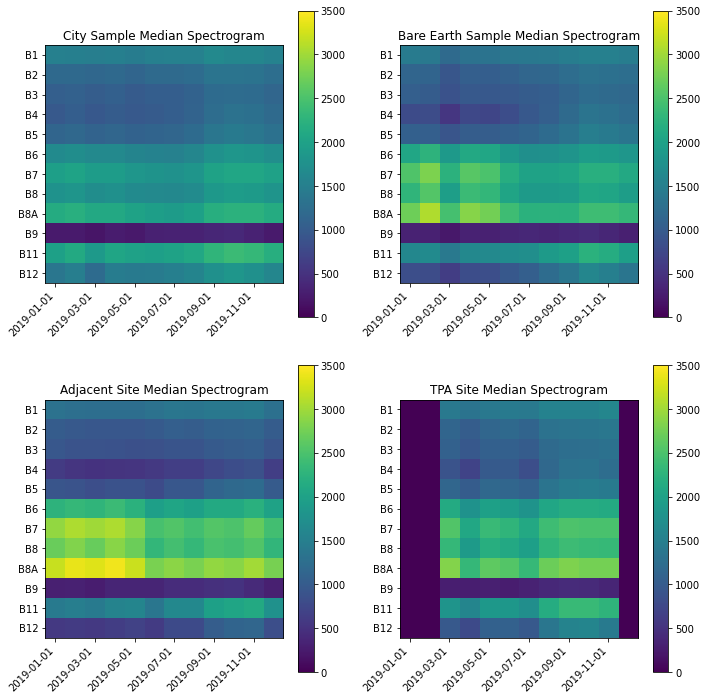

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.median(city_spectrograms, axis=0), vmin=0, vmax=3500)
plt.xticks(range(0,len(dates),2), dates[0::2], rotation=45, ha='right')
plt.yticks(range(len(band_descriptions)), band_descriptions)
plt.colorbar()
plt.title('City Sample Median Spectrogram')

plt.subplot(2,2,2)
plt.imshow(np.median(bare_earth_spectrograms, axis=0), vmin=0, vmax=3500)
plt.xticks(range(0,len(dates),2), dates[0::2], rotation=45, ha='right')
plt.yticks(range(len(band_descriptions)), band_descriptions)
plt.colorbar()
plt.title('Bare Earth Sample Median Spectrogram')

plt.subplot(2,2,3)
plt.imshow(np.median(adjacent_spectrograms, axis=0), vmin=0, vmax=3500)
plt.xticks(range(0,len(dates),2), dates[0::2], rotation=45, ha='right')
plt.yticks(range(len(band_descriptions)), band_descriptions)
plt.colorbar()
plt.title('Adjacent Site Median Spectrogram')

plt.subplot(2,2,4)
plt.imshow(np.median(positive_spectrograms, axis=0), vmin=0, vmax=3500)
plt.xticks(range(0,len(dates),2), dates[0::2], rotation=45, ha='right')
plt.yticks(range(len(band_descriptions)), band_descriptions)
plt.colorbar()
plt.title('TPA Site Median Spectrogram')
plt.tight_layout()
plt.show()

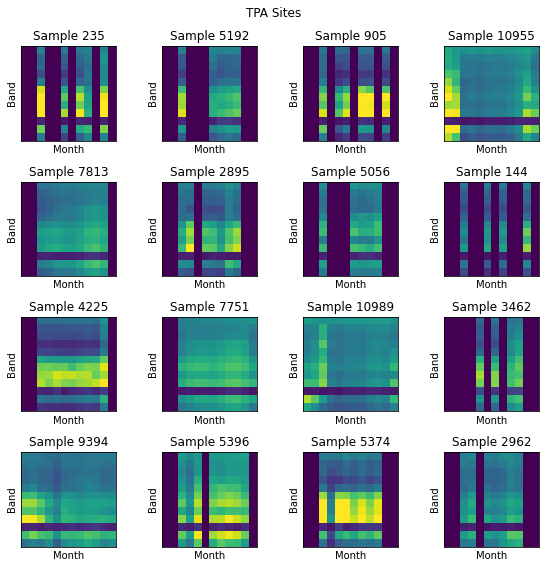

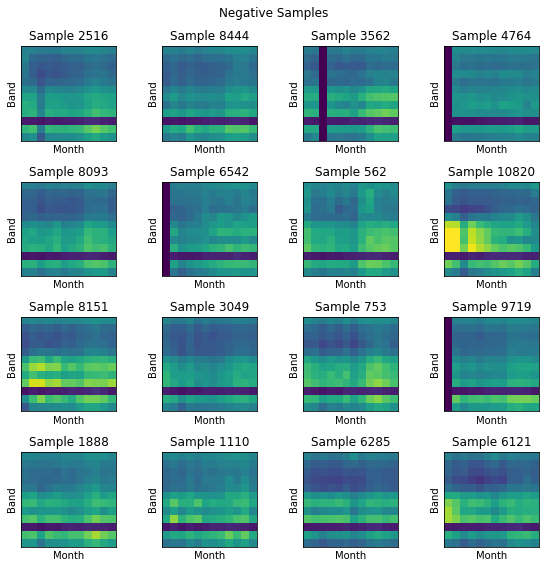

In [13]:
plt.figure(figsize=(8,8))
for i in range(16):
    index = np.random.randint(len(positive_spectrograms))
    plt.subplot(4,4,i + 1)
    plt.imshow(positive_spectrograms[index], vmin=0, vmax=3500)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Month')
    plt.ylabel('Band')
    plt.title('Sample ' + str(index))
plt.suptitle('TPA Sites')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
for i in range(16):
    index = np.random.randint(len(positive_spectrograms))
    plt.subplot(4,4,i + 1)
    plt.imshow(negative_spectrograms[index], vmin=0, vmax=3500)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Month')
    plt.ylabel('Band')
    plt.title('Sample ' + str(index))
plt.suptitle('Negative Samples')
plt.tight_layout()
plt.show()

In [14]:
# Fill empty bands with mean value
positive_fill = np.copy(positive_spectrograms)
for index, sample in enumerate(positive_spectrograms):
    for band_num, band in enumerate(sample):
        band[band == 0.0] = np.mean(band)
        positive_fill[index, band_num] = band
        
# Attempt to fill empty bands
negative_fill = np.copy(negative_spectrograms)
for index, sample in enumerate(negative_spectrograms):
    for band_num, band in enumerate(sample):
        band[band == 0.0] = np.mean(band)
        negative_fill[index, band_num] = band

In [ ]:
# Attempt to interpolate empty bands. Doesn't work at the moment
positive_interp = np.copy(positive_spectrograms)
for sample in range(len(positive_spectrograms)):
    for band in sample:
        
    # middle samples
    for month in range(1,11):
        if sum(positive_spectrograms[sample,:,month] == 0) > 6:
            interpolated = (positive_spectrograms[sample,:,month - 1] + positive_spectrograms[sample,:,month + 1]) // 2
            positive_interp[sample,:,month] = interpolated

    # front edge
    if sum(positive_spectrograms[sample,:,0] == 0) > 6:
        interpolated =  positive_spectrograms[sample,:,1]
        positive_interp[sample,:,0] = interpolated

    # front edge
    if sum(positive_spectrograms[sample,:,11] == 0) > 6:
        interpolated =  positive_spectrograms[sample,:,11]
        positive_interp[sample,:,0] = interpolated
        
negative_interp = np.copy(negative_spectrograms)
for sample in range(len(negative_spectrograms)):
    # middle samples
    for month in range(1,11):
        if sum(negative_spectrograms[sample,:,month] == 0) > 6:
            interpolated = (negative_spectrograms[sample,:,month - 1] + negative_spectrograms[sample,:,month + 1]) // 2
            negative_interp[sample,:,month] = interpolated

    # front edge
    if sum(negative_spectrograms[sample,:,0] == 0) > 6:
        interpolated =  negative_spectrograms[sample,:,1]
        negative_interp[sample,:,0] = interpolated

    # front edge
    if sum(negative_spectrograms[sample,:,11] == 0) > 6:
        interpolated =  negative_spectrograms[sample,:,11]
        negative_interp[sample,:,0] = interpolated

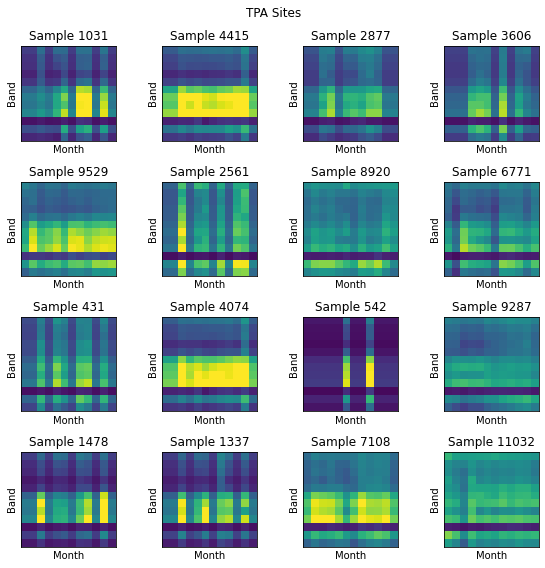

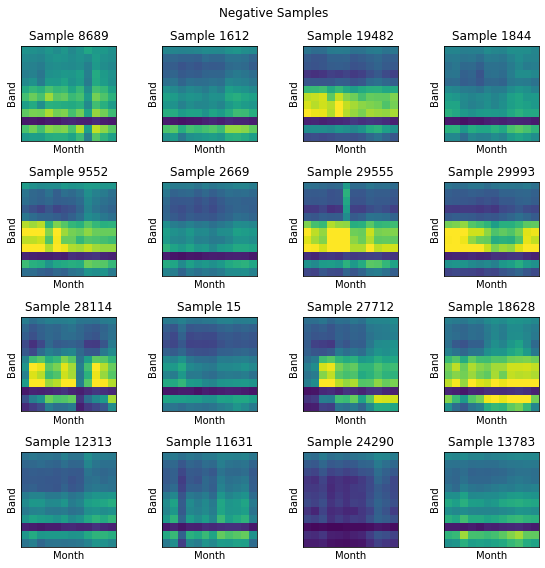

In [15]:
plt.figure(figsize=(8,8))
for i in range(16):
    index = np.random.randint(len(positive_fill))
    plt.subplot(4,4,i + 1)
    plt.imshow(positive_spectrograms[index], vmin=0, vmax=3500)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Month')
    plt.ylabel('Band')
    plt.title('Sample ' + str(index))
plt.suptitle('TPA Sites')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
for i in range(16):
    index = np.random.randint(len(negative_fill))
    plt.subplot(4,4,i + 1)
    plt.imshow(negative_spectrograms[index], vmin=0, vmax=3500)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Month')
    plt.ylabel('Band')
    plt.title(f'Sample {index}')
plt.suptitle('Negative Samples')
plt.tight_layout()
plt.show()

## Process Data for Network Training

In [16]:
def normalize(x):
    return np.array(x) / 3000

In [17]:
x = np.concatenate((positive_fill, negative_fill))
y = np.concatenate((np.ones(len(positive_fill)), np.zeros(len(negative_fill))))

x, y = shuffle(x, y, random_state=42)
x = normalize(x)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
#x_positive_test = np.expand_dims(x_positive_test, -1)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Num Train:		 33734
Num Test:		 8434
Percent Negative Train:	 72.8
Percent Negative Test:	 73.2


In [19]:
input_shape = np.shape(x_train[0])
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(8, kernel_size=(3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2)),
        layers.Conv2D(16, kernel_size=(3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2)),
        layers.Flatten(),
        #layers.Dense(64, activation="relu"),
        #layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [20]:
model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=[#keras.metrics.Recall(thresholds=(0.9), name='precision'), 
                       #keras.metrics.Precision(thresholds=(0.9), name='recall'),
                       #keras.metrics.AUC(curve='PR', name='auc'),
                       "accuracy"]
             )

In [21]:
batch_size = 128
epochs = 30

print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train[:,1] == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test[:,1] == 0.0) / len(y_test):.1f}")

model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data = (x_test, y_test),
          #validation_split=0.1,
          #class_weight = {0: negative_weight, 1: positive_weight}
          #class_weight = {0: 2, 1: 1}
         )

Num Train:		 33734
Num Test:		 8434
Percent Negative Train:	 72.8
Percent Negative Test:	 73.2
Epoch 1/30
264/264 [==============================] - 1s 5ms/step - loss: 0.4944 - accuracy: 0.7903 - val_loss: 0.3595 - val_accuracy: 0.8626
Epoch 2/30
264/264 [==============================] - 1s 4ms/step - loss: 0.3638 - accuracy: 0.8618 - val_loss: 0.3202 - val_accuracy: 0.8759
Epoch 3/30
264/264 [==============================] - 1s 4ms/step - loss: 0.3337 - accuracy: 0.8686 - val_loss: 0.2954 - val_accuracy: 0.8827
Epoch 4/30
264/264 [==============================] - 1s 4ms/step - loss: 0.3052 - accuracy: 0.8767 - val_loss: 0.2694 - val_accuracy: 0.8912
Epoch 5/30
264/264 [==============================] - 1s 4ms/step - loss: 0.2785 - accuracy: 0.8863 - val_loss: 0.2432 - val_accuracy: 0.8984
Epoch 6/30
264/264 [==============================] - 1s 4ms/step - loss: 0.2521 - accuracy: 0.8948 - val_loss: 0.2216 - val_accuracy: 0.9063
Epoch 7/30
264/264 [==============================] -

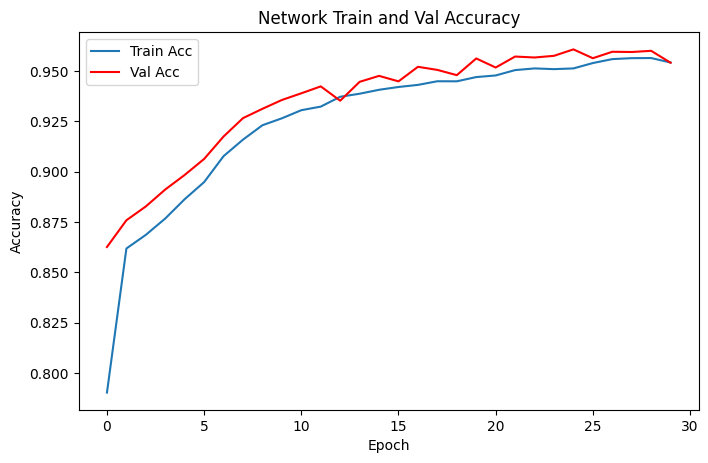

In [22]:
plt.figure(figsize=(8,5), dpi=100, facecolor=(1,1,1))
plt.plot(model.history.history['accuracy'], label='Train Acc')
plt.plot(model.history.history['val_accuracy'], c='r', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Network Train and Val Accuracy')
plt.show()

## Test Network

In [116]:
# Enter rect width in degrees (0.035 max recommended) and site coordinates
rect_width = 0.005
site_coords = [115.350242, -8.562121]
name = 'temesi'
start_date = '2019-01-01'
patch_history = get_history([site_coords], 
                            [name], 
                            rect_width,
                            num_months = 12,
                            start_date = start_date)

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:03<00:39,  3.63s/it]

 17%|█▋        | 2/12 [00:14<00:57,  5.71s/it]

 25%|██▌       | 3/12 [00:15<00:40,  4.52s/it]

 33%|███▎      | 4/12 [00:25<00:48,  6.11s/it]

 42%|████▏     | 5/12 [00:30<00:39,  5.62s/it]

 50%|█████     | 6/12 [00:37<00:36,  6.01s/it]

 58%|█████▊    | 7/12 [00:40<00:25,  5.17s/it]

 67%|██████▋   | 8/12 [00:43<00:18,  4.64s/it]

 75%|███████▌  | 9/12 [00:53<00:18,  6.12s/it]

 83%|████████▎ | 10/12 [00:55<00:10,  5.00s/it]

 92%|█████████▏| 11/12 [00:58<00:04,  4.31s/it]

100%|██████████| 12/12 [01:05<00:00,  5.44s/it]


In [117]:
test_data = create_spectrogram_dataset(patch_history, list(patch_history.keys()))
for index, sample in enumerate(test_data):
    for band_num, band in enumerate(sample):
        band[band == 0.0] = np.mean(band)
        test_data[index, band_num] = band

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


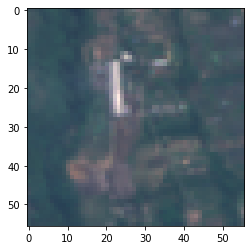

In [118]:
site_data = patch_history['2019-06-01']['temesi']
rgb = np.stack((site_data['B4'], site_data['B3'], site_data['B2']), axis=-1)
plt.imshow(normalize(rgb))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


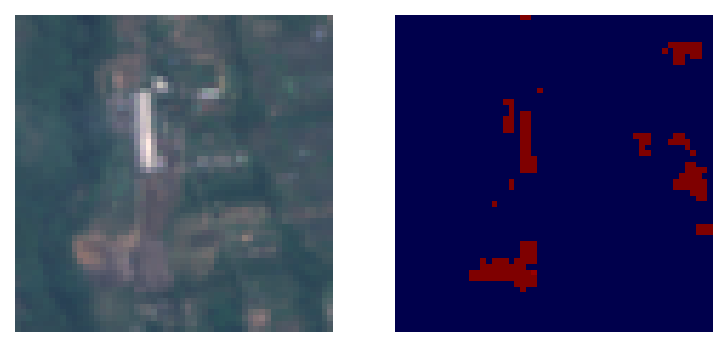

In [119]:
preds = model.predict(np.expand_dims(test_data, axis=-1))[:,1]
width = int(np.sqrt(test_data.shape[0]))
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(normalize(rgb))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.reshape(preds, (width, width)), cmap='seismic', vmin=0.8)
plt.axis('off')
plt.show()

In [130]:
x_flat = [sample.flatten() for sample in x]
x_flat = np.array(x_flat)
x_flat.shape

(42168, 144)

In [150]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
num_samples = 10000
reduced = umap.UMAP(n_components=2).fit_transform(x_flat[:num_samples])

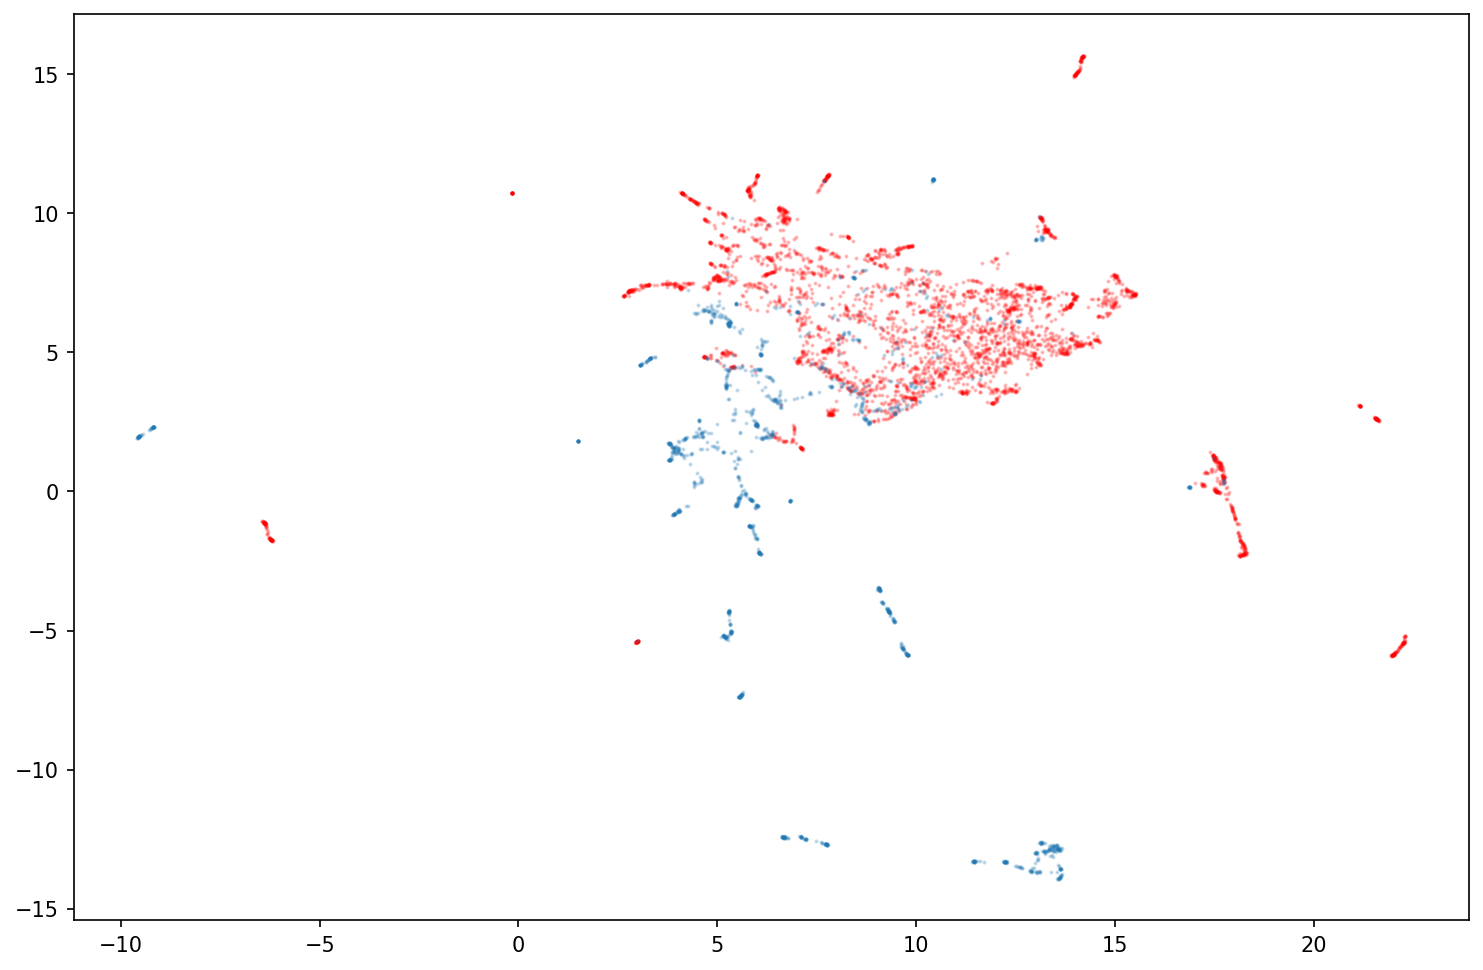

In [153]:
plt.figure(figsize=(12,8), dpi=150)
plt.scatter(reduced[y[:num_samples] == 0.,0], reduced[y[:num_samples] == 0.,1], alpha=.21, s=1, c='r')
plt.scatter(reduced[y[:num_samples] == 1.,0], reduced[y[:num_samples] == 1.,1], alpha=.21, s=1)
plt.show()

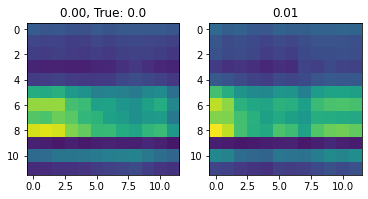

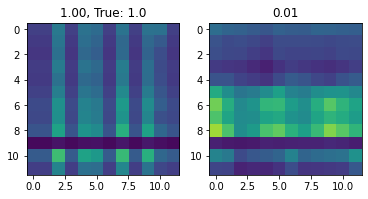

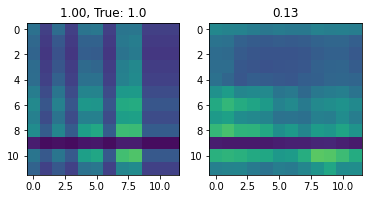

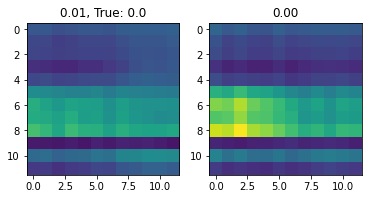

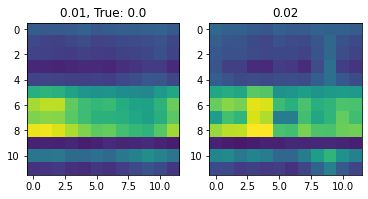

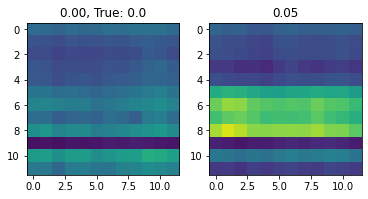

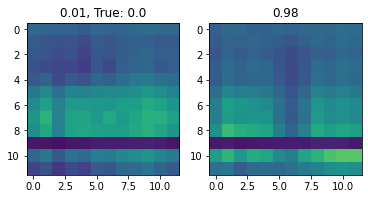

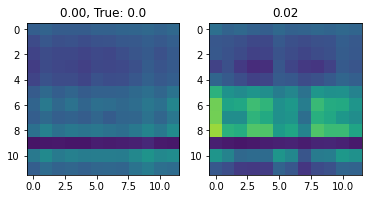

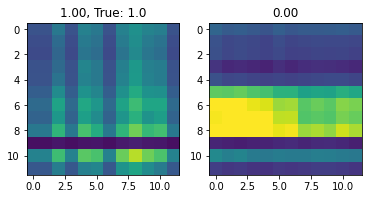

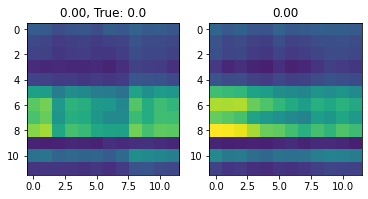

In [126]:
for i in range(10):
    index = np.random.randint(len(test_data))
    plt.subplot(1,2,1)
    plt.imshow(x[index], vmin=0, vmax=1.5)
    plt.title(f"{model.predict(np.expand_dims(x[index:index+1], axis=-1))[0][1]:.2f}, True: {y[index]}")
    plt.subplot(1,2,2)
    plt.imshow(normalize(test_data[index]), vmin=0, vmax=1.5)
    plt.title(f"{model.predict(np.expand_dims(normalize(test_data[index:index+1]), axis=-1))[0][1]:.2f}")
    plt.show()

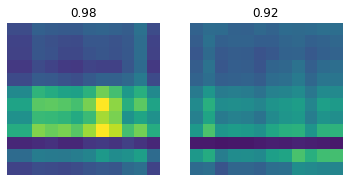

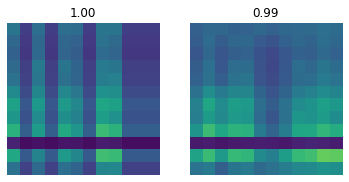

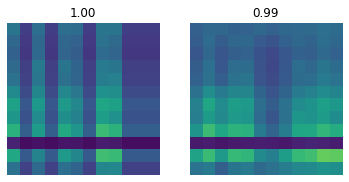

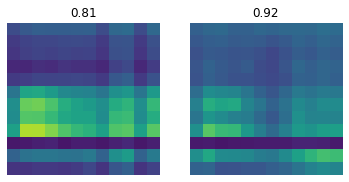

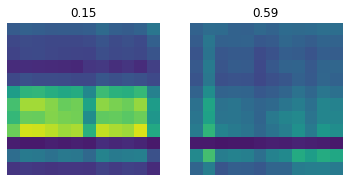

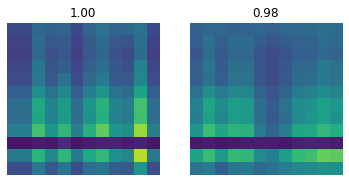

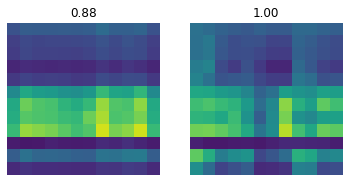

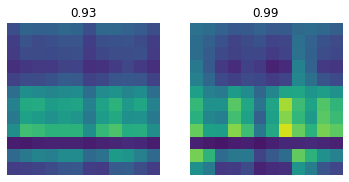

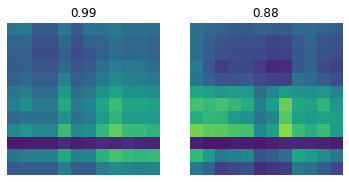

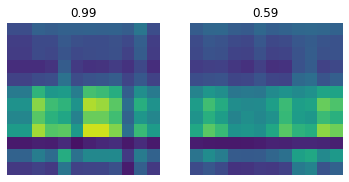

In [157]:
positives = test_data[preds > 0.8]
train_positives = x[y == 1]
for i in range(10):
    index = np.random.randint(len(positives))
    plt.subplot(1,2,1)
    plt.imshow(train_positives[index], vmin=0, vmax=1.5)
    plt.title(f"{model.predict(np.expand_dims(train_positives[index:index+1], axis=-1))[0][1]:.2f}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(normalize(positives[index]), vmin=0, vmax=1.5)
    plt.title(f"{model.predict(np.expand_dims(normalize(positives[index:index+1]), axis=-1))[0][1]:.2f}")
    plt.axis('off')
    plt.show()

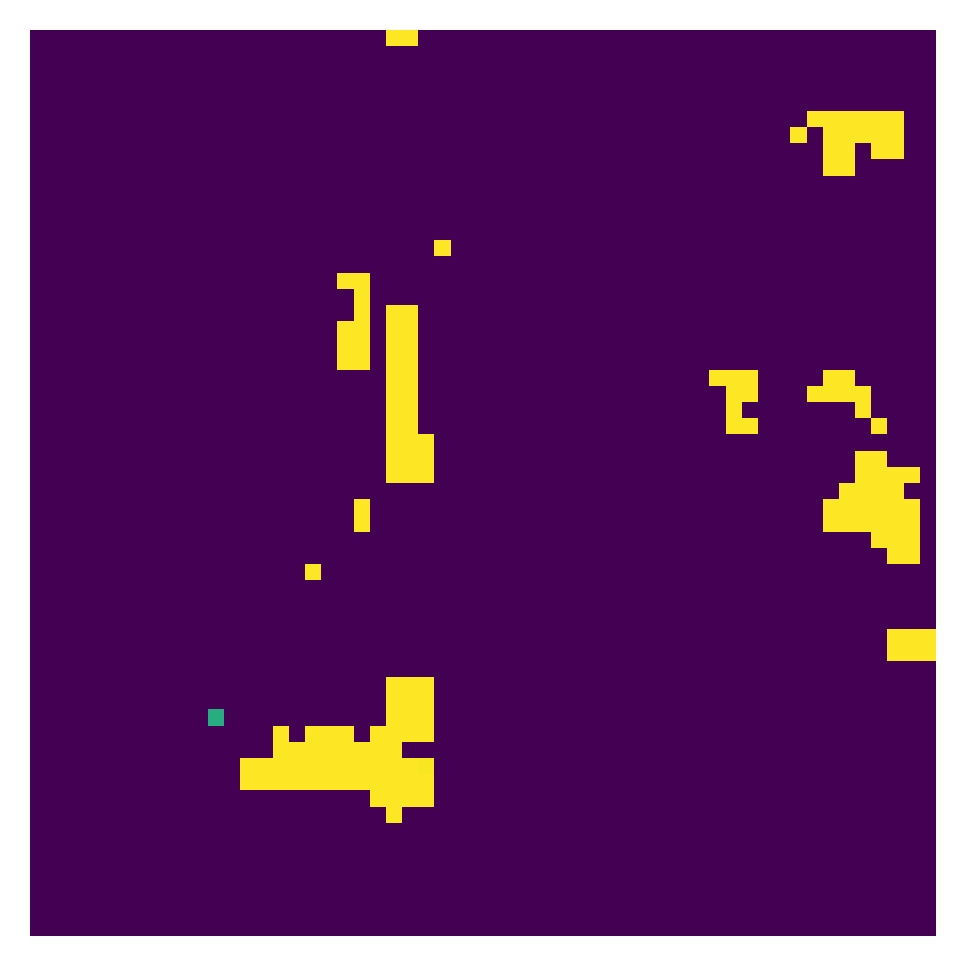

In [123]:
pred_thresh = np.copy(preds.reshape(width, width))
plt.figure(dpi=300)
plt.imshow(pred_thresh)
plt.axis('off')
plt.show()

In [125]:
sum(preds > 0.9)

162

In [85]:
def spectrogram_predict(dataset, site_name, model):
        rgb_stack = []
        preds_stack = []
        spectrogram_list = []
        
        width, height = np.shape(dataset[dates[0]][site]['B2'])
        dates = list(patch_histories.keys())
        rgb = np.stack((patch_histories[dates[0]][site_name]['B4'],
                        patch_histories[dates[0]][site_name]['B3'],
                        patch_histories[dates[0]][site_name]['B2']), axis=-1)
        for i in range(width):
            for j in range(height):
                spectrogram = []
                for date in tqdm(dates):
                    pixel_vector = []
                    for band in band_descriptions:
                        if dataset[date][site][band][i][j] != -999:
                            pixel_vector.append(dataset[date][site][band][i][j])
                        else:
                            pixel_vector.append(0)
                        spectrogram.append(pixel_vector)

                        else:
                            spectrogram.append([0] * len(band_descriptions))
                spectrogram_list.append(np.transpose(spectrogram))
                rgb_stack.append(rgb)
        preds = model.predict(np.expand_dims(normalize(spectrogram_list), axis=-1))
        preds = np.reshape(preds[:,1], (width, height))
    return preds, rgb_stack

In [86]:
positive_histories['2019-01-01'].keys()

dict_keys(['TPA Jungut Batu', 'TPA Biaung', 'TPA Sente', 'TPA Regional Bangli', 'TPA Peh', 'TPA Temesi', 'TPA Bengkala', 'TPA Bebandem', 'TPA Mandung', 'TPA Regional Suwung'])

In [87]:
preds, rgb = spectrogram_predict(positive_histories, dates)

In [89]:
np.array(rgb).shape

(598, 26, 23, 3)

In [1]:
plt.imshow(rgb / 3000)
plt.show()
plt.imshow(preds)

NameError: name 'plt' is not defined

In [90]:
def make_predictions(site_name, dates):
    with open(os.path.join(DATA_DIR, site_name + "_0.03_patch.pkl"), 'rb') as file:
        test_image = pickle.load(file)

    preds, rgb = spectrogram_predict(test_image, dates)
    plt.figure(figsize=(8,8), dpi=150)
    plt.subplot(1,3,1)
    plt.imshow(normalize(rgb))
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(preds, cmap = 'seismic', vmin = 0, vmax=1)
    #plt.colorbar()
    plt.axis('off')
    plt.subplot(1,3,3)
    heatmap = np.copy(rgb) / 3000
    heatmap[:,:,0] += preds
    plt.imshow(heatmap, cmap = 'seismic', vmin = 0, vmax=1)
    #plt.colorbar()
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return preds
    

In [ ]:
DATA_DIR = '../data'
dates = list(positive_histories.keys())[:12]
#site_names = ['bare_earth_4', 'tpa_babandem', 'city_7', 'tpa_bangli', 'tpa_biaung', 'tpa_mandung', 'tpa_jimbaran']
preds = make_predictions('city_7', dates)

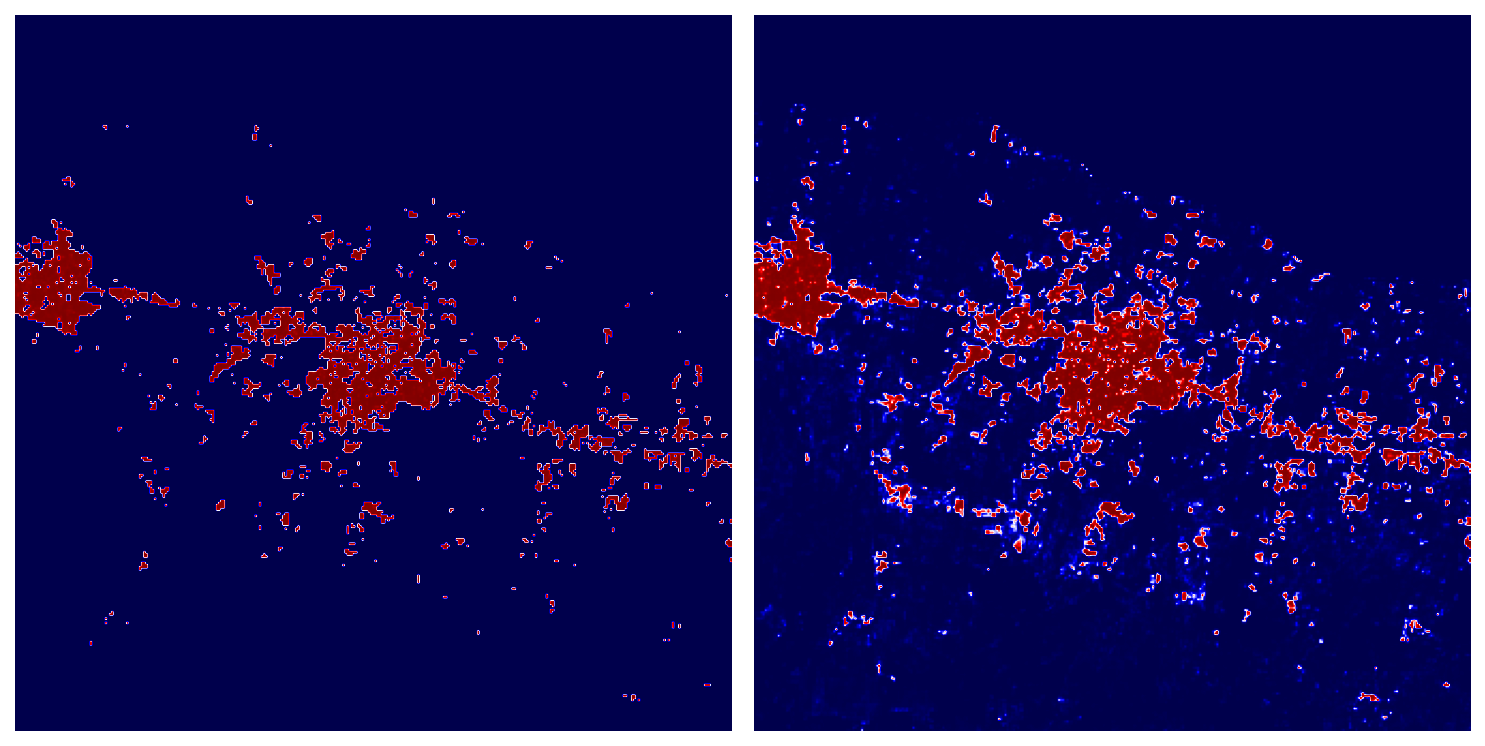

In [878]:
masked = np.copy(preds)
masked[masked < 0.9] = 0
plt.figure(figsize=(10,10), dpi=150)
plt.subplot(1,2,1)
plt.imshow(masked, cmap='seismic')
#plt.colorbar()
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(preds, cmap='seismic')
#plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


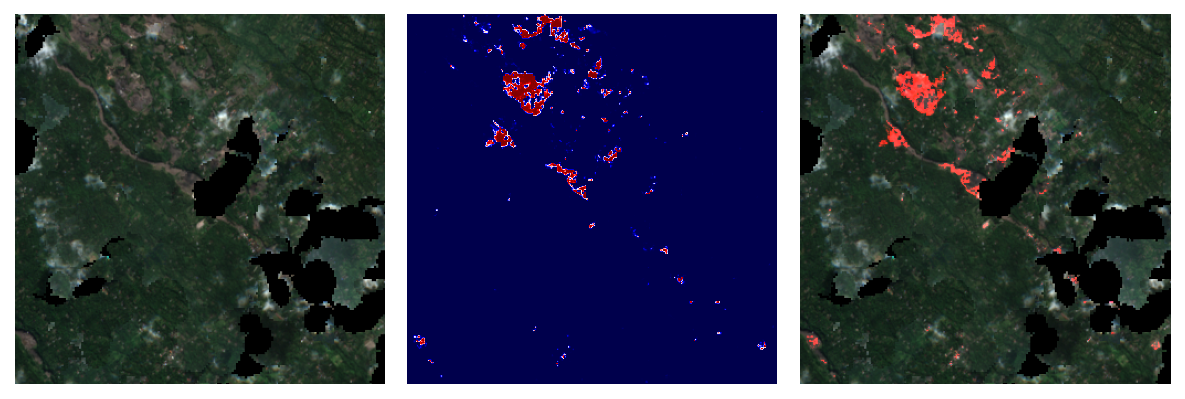

In [882]:
DATA_DIR = '../data'
dates = list(positive_histories.keys())[:12]
#site_names = ['bare_earth_4', 'tpa_babandem', 'city_7', 'tpa_bangli', 'tpa_biaung', 'tpa_mandung', 'tpa_jimbaran']
preds = make_predictions('tpa_babandem', dates)

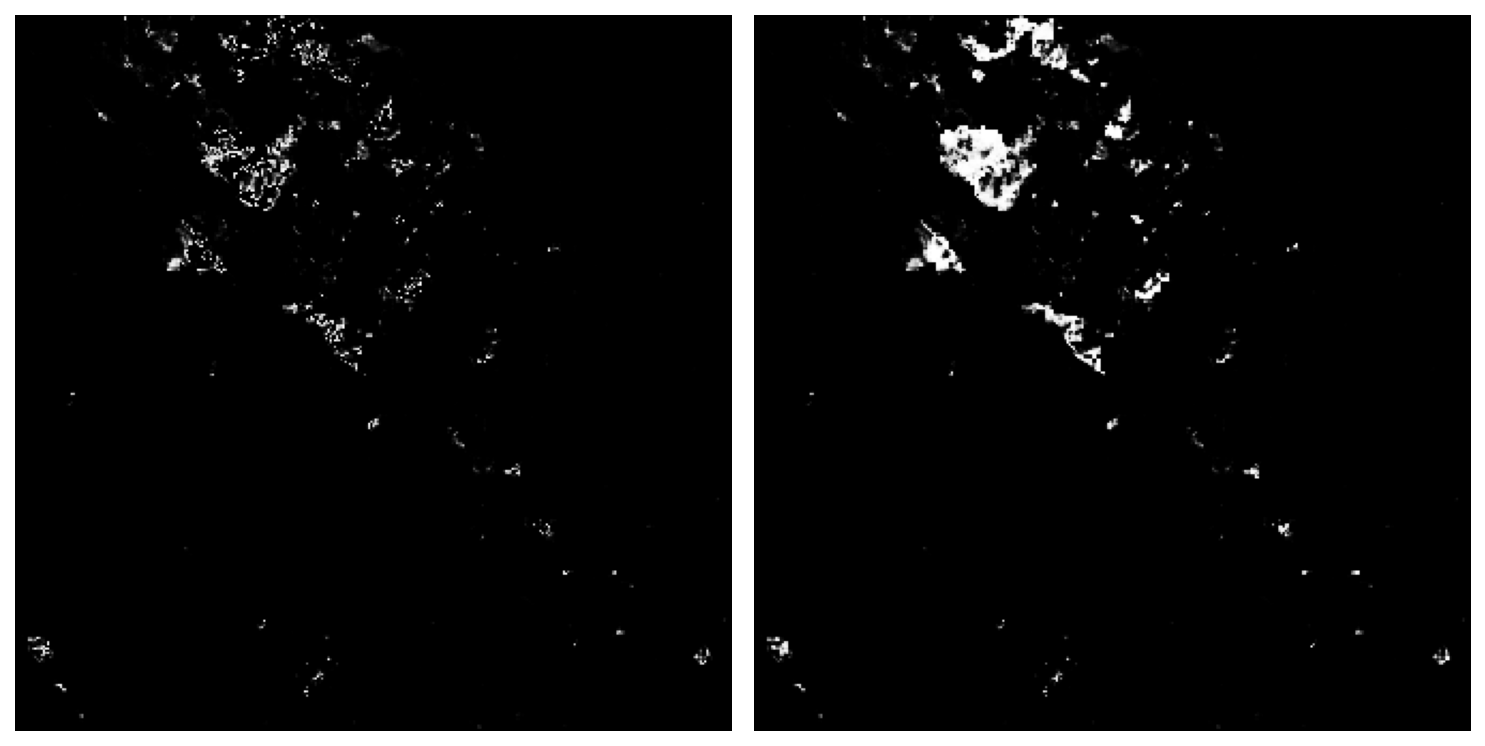

In [883]:
masked = np.copy(preds)
masked[masked > 0.9] = 0
plt.figure(figsize=(10,10), dpi=150)
plt.subplot(1,2,1)
plt.imshow(masked, cmap='gray')
#plt.colorbar()
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(preds, cmap='gray')
#plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

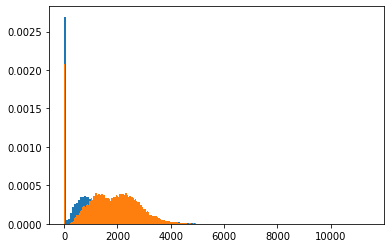

In [583]:
plt.hist(negative_spectrograms.flatten(), 150, density=True);
plt.hist(positive_spectrograms.flatten(), 150, density=True);
plt.show()

In [817]:
negatives = pd.DataFrame(np.median(city_spectrograms, axis=0), index=band_descriptions).transpose()
negatives['band'] = band_descriptions
negatives['class'] = ['negative'] * 12
display(negatives)
positives = pd.DataFrame(np.median(positive_spectrograms, axis=0), index=band_descriptions).transpose()
positives['band'] = band_descriptions
positives['class'] =  ['positive'] * 12

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,band,class
0,536.0,543.0,704.5,657.5,1047.0,1531.0,1702.5,1588.0,1834.0,1946.0,1880.0,1366.0,B1,negative
1,616.0,548.0,750.5,767.5,1193.0,1659.0,1841.0,1746.0,2001.5,2079.0,2161.0,1705.0,B2,negative
2,517.0,415.0,637.0,587.0,1065.0,1530.0,1699.0,1550.0,1851.0,1913.5,1936.0,1373.0,B3,negative
3,547.0,526.5,705.0,728.0,1106.0,1572.5,1746.0,1669.0,1885.0,1946.5,2100.0,1665.0,B4,negative
4,566.0,522.0,690.5,716.0,1088.0,1525.5,1694.5,1607.0,1833.0,1869.0,2062.0,1657.0,B5,negative
5,575.5,547.0,690.0,736.0,1060.0,1433.0,1588.0,1547.0,1721.5,1795.0,1957.5,1594.5,B6,negative
6,610.5,584.0,727.0,806.0,1108.5,1450.0,1602.0,1561.0,1728.0,1766.0,2022.0,1670.5,B7,negative
7,649.0,626.0,786.0,888.5,1209.0,1541.0,1682.5,1642.0,1829.0,1873.0,2150.0,1799.0,B8,negative
8,764.0,735.5,905.0,1026.0,1341.0,1666.0,1827.0,1791.0,1968.5,1996.5,2349.5,1983.0,B8A,negative
9,770.0,749.0,947.0,1102.0,1437.5,1740.0,1896.5,1870.0,2042.0,2084.0,2454.0,2084.0,B9,negative


In [818]:
both = negatives.append(positives)
both

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,band,class
0,536.0,543.0,704.5,657.5,1047.0,1531.0,1702.5,1588.0,1834.0,1946.0,1880.0,1366.0,B1,negative
1,616.0,548.0,750.5,767.5,1193.0,1659.0,1841.0,1746.0,2001.5,2079.0,2161.0,1705.0,B2,negative
2,517.0,415.0,637.0,587.0,1065.0,1530.0,1699.0,1550.0,1851.0,1913.5,1936.0,1373.0,B3,negative
3,547.0,526.5,705.0,728.0,1106.0,1572.5,1746.0,1669.0,1885.0,1946.5,2100.0,1665.0,B4,negative
4,566.0,522.0,690.5,716.0,1088.0,1525.5,1694.5,1607.0,1833.0,1869.0,2062.0,1657.0,B5,negative
5,575.5,547.0,690.0,736.0,1060.0,1433.0,1588.0,1547.0,1721.5,1795.0,1957.5,1594.5,B6,negative
6,610.5,584.0,727.0,806.0,1108.5,1450.0,1602.0,1561.0,1728.0,1766.0,2022.0,1670.5,B7,negative
7,649.0,626.0,786.0,888.5,1209.0,1541.0,1682.5,1642.0,1829.0,1873.0,2150.0,1799.0,B8,negative
8,764.0,735.5,905.0,1026.0,1341.0,1666.0,1827.0,1791.0,1968.5,1996.5,2349.5,1983.0,B8A,negative
9,770.0,749.0,947.0,1102.0,1437.5,1740.0,1896.5,1870.0,2042.0,2084.0,2454.0,2084.0,B9,negative


In [834]:
a = both.groupby(by=['class'])

/Users/ckruse/.envs/plastics/lib/python3.6/site-packages/joypy/joyplot.py:548: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=h_pad)


<Figure size 864x432 with 0 Axes>

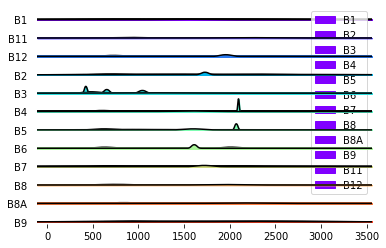

In [837]:
#both = negatives.append(positives).groupby(['band'])
from matplotlib import cm
plt.figure(figsize=(12,6))
fig, ax = joypy.joyplot(both, by='band', colormap=cm.rainbow, y)


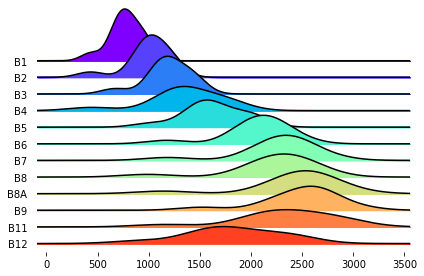

In [821]:
#both = negatives.append(positives).groupby(['band'])
from matplotlib import cm
fig, ax = joypy.joyplot(positives, colormap=cm.rainbow)

In [839]:
negatives = pd.DataFrame(np.median(adjacent_spectrograms, axis=0).T, columns=band_descriptions)
negatives['class'] = ['negative'] * 12
positives = pd.DataFrame(np.median(positive_spectrograms, axis=0).T, columns=band_descriptions)
positives['class'] =  ['positive'] * 12

In [628]:
import joypy

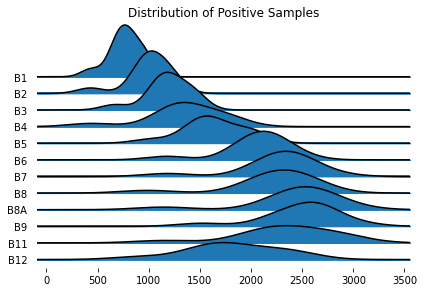

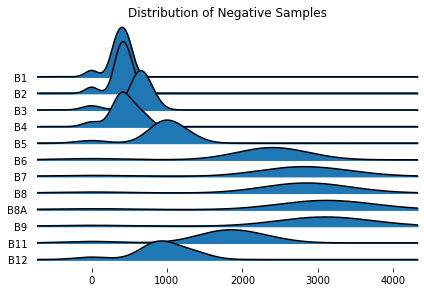

In [840]:
fig, ax = joypy.joyplot(positives)
plt.title('Distribution of Positive Samples')
fig2, ax2 = joypy.joyplot(negatives)
plt.title('Distribution of Negative Samples')
plt.show()

In [ ]:
def create_joyplot(preds, labels, interval):
    interval = interval
    errors = []
    timespan = []
    error_colors = []
    for time_val in range(0,int(np.max(labels)-interval), interval):
        indexes = np.where((labels >= time_val) & (labels  < time_val + interval))
        error = preds[indexes] - labels[indexes]
        errors.append(error)
        error_colors.append(np.median(error))
        if time_val % 12 == 0:
            timespan.append(str(time_val) + " min")
        else: timespan.append(None)


    orig_cmap = cm.RdYlBu
    # Create a normalization scheme so that colorbar has correct legend
    norm = plt.Normalize(np.min(error_colors), np.max(error_colors))
    # Create a colormap based on avg error at each interval
    error_cmap = ListedColormap(orig_cmap(norm(error_colors)))
    # Create a color bar
    sm = cm.ScalarMappable(cmap=orig_cmap, norm=norm)
    sm.set_array([])

    fig, axes = joypy.joyplot(errors, labels=timespan, x_range=[-30, 15], overlap=1, figsize=(6,5), colormap=error_cmap, title="Distribution of Error Grouped by Time to Eruption", fade=False, linewidth=0.5,range_style='all', grid='x')
    fig.colorbar(sm, ax=axes, label="Median Error (minutes)")
    plt.xlabel("Error (min)")
    ax = axes[-1]
    ax.yaxis.set_label_position("left")
    ax.set_ylabel("Time until next eruption (min)")
    ax.yaxis.set_label_coords(-0.18,0.5)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_visible(True)
    plt.show()
    fig.savefig("Distribution of Error by Time to Eruption.png", dpi=300, bbox_inches='tight', pad_inches=0.1)